# MSAS Cycling Aging: Knee EFC Analysis

This notebook computes knee points (EFC) for cycling-aging cells and summarizes
how many cells have a detected knee, and the distribution of knee EFC values.

Notes:
- Uses the KneeEFCLabelAnnotator (piecewise linear intersection).
- Uses CC-only Q with tail CV trimming.
- `min_points` is set low for small sample sizes; adjust if needed.


In [85]:
from pathlib import Path
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import batteryml
from batteryml.data.battery_data import BatteryData
from batteryml.label.knee_efc import KneeEFCLabelAnnotator

In [86]:
def find_repo_root(start: Path) -> Path:
    for p in [start, *start.parents]:
        if (p / "batteryml").exists() and (p / "configs").exists():
            return p
    return start

env_root = os.environ.get("BATTERYML_REPO_ROOT")
if env_root:
    repo_root = Path(env_root)
else:
    repo_root = find_repo_root(Path.cwd())
    if not (repo_root / "configs").exists():
        pkg_root = Path(batteryml.__file__).resolve().parents[1]
        repo_root = find_repo_root(pkg_root)

processed_dir = repo_root / "data/processed/MSAS"
if not processed_dir.exists():
    raise FileNotFoundError("Missing data/processed/MSAS. Run MSAS preprocessing first.")

In [87]:
allowed_tags = ["ET_T23", "CU", "exCU", "AT_T23"]
min_points = 3
min_slope_drop = 1e-5  # increase if too many knees are detected
threshold_efc = 600.0

annotator = KneeEFCLabelAnnotator(
    baseline_efc=0.0,
    max_abs_efc_error=400.0,
    allowed_tags=allowed_tags,
    include_cv=False,
    cc_current_fraction=0.98,
    cv_voltage_window_in_V=0.05,
    min_points=min_points,
    min_slope_drop=min_slope_drop,
    monotonic=True,
)

In [88]:
rows = []
cycling_files = [p for p in processed_dir.glob("*.pkl") if "_TP_z" in p.stem]

for path in sorted(cycling_files):
    cell = BatteryData.load(path)
    knee = float(annotator.process_cell(cell))
    rows.append({
        "cell_id": cell.cell_id,
        "knee_efc": knee if np.isfinite(knee) else np.nan,
    })

df = pd.DataFrame(rows)
df["has_knee"] = df["knee_efc"].notna()
df["knee_before_600"] = (df["knee_efc"] <= threshold_efc)

total = len(df)
count_knee = int(df["has_knee"].sum())
count_before = int(df[df["has_knee"]]["knee_before_600"].sum())

print("cycling cells", total)
print("knee detected", count_knee, f"({count_knee / max(total,1):.1%})")
print("knee <= 600 EFC", count_before, f"({count_before / max(count_knee,1):.1%})")

df.head()

cycling cells 147
knee detected 26 (17.7%)
knee <= 600 EFC 21 (80.8%)


,cell_id,knee_efc,has_knee,knee_before_600
0,MSAS_S1_TP_z01_01,130.986115,True,True
1,MSAS_S1_TP_z01_02,NaN,False,False
2,MSAS_S1_TP_z01_03,NaN,False,False
3,MSAS_S1_TP_z02_01,NaN,False,False
4,MSAS_S1_TP_z02_02,NaN,False,False


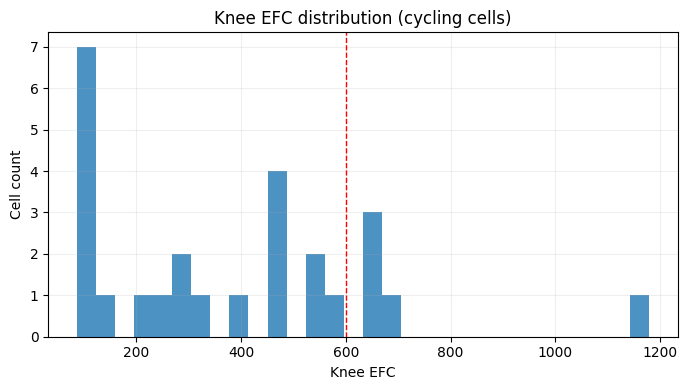

In [89]:
fig, ax = plt.subplots(figsize=(7, 4))
vals = df["knee_efc"].dropna().values
ax.hist(vals, bins=30, alpha=0.8, color="#1f77b4")
ax.axvline(threshold_efc, color="red", linestyle="--", linewidth=1)
ax.set_xlabel("Knee EFC")
ax.set_ylabel("Cell count")
ax.set_title("Knee EFC distribution (cycling cells)")
ax.grid(True, alpha=0.2)
plt.tight_layout()

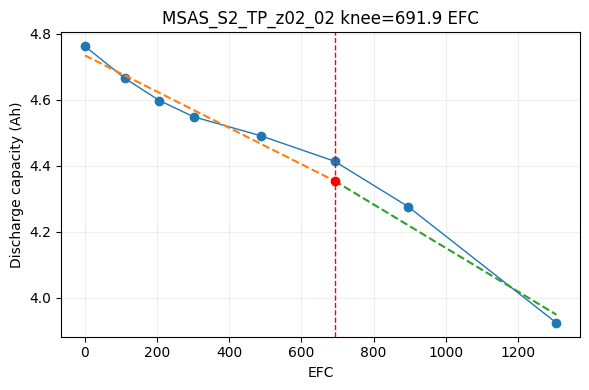

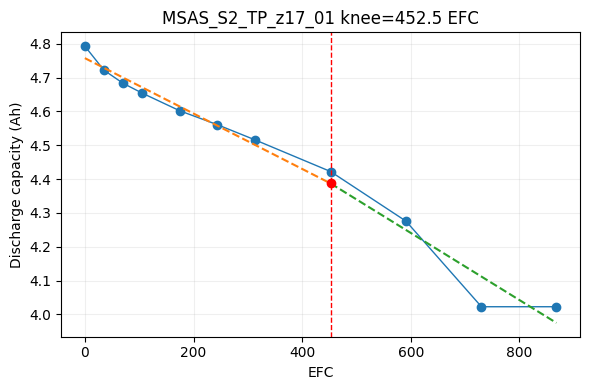

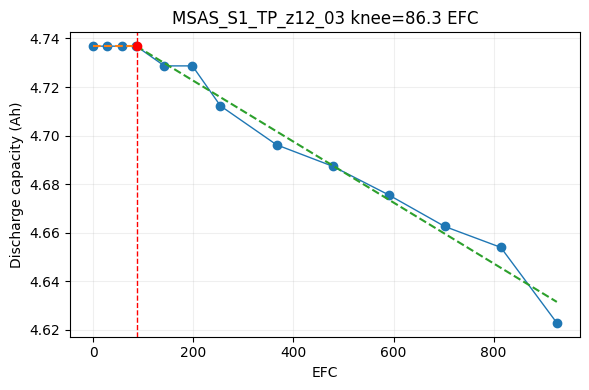

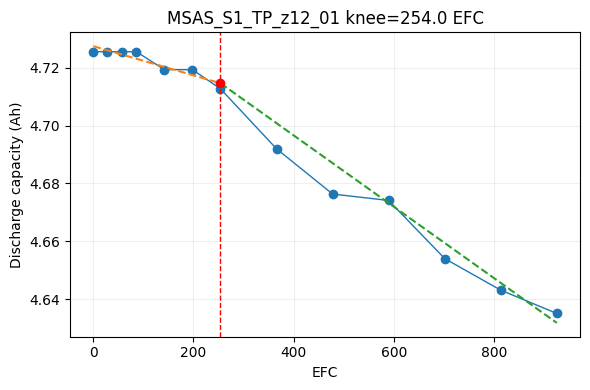

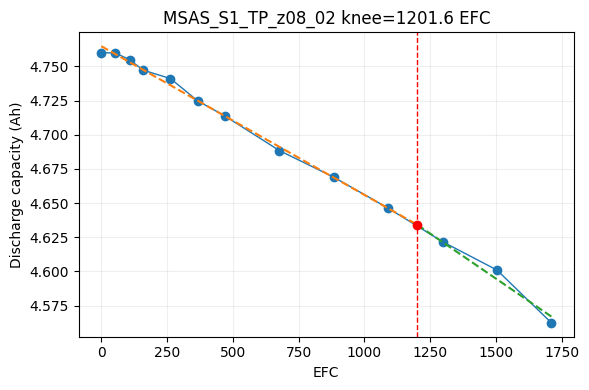

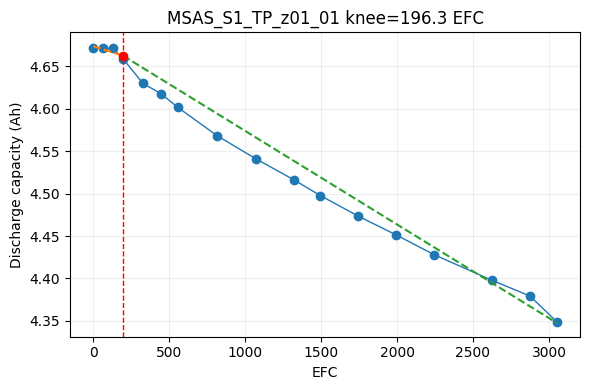

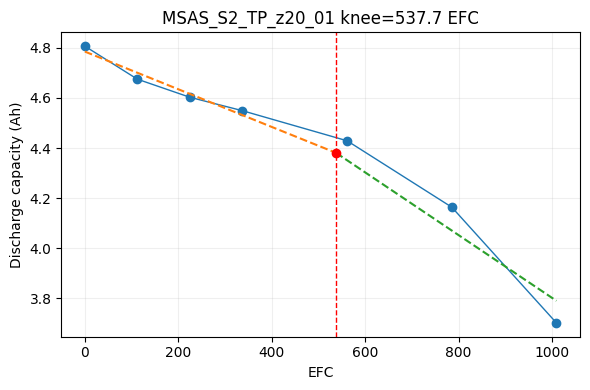

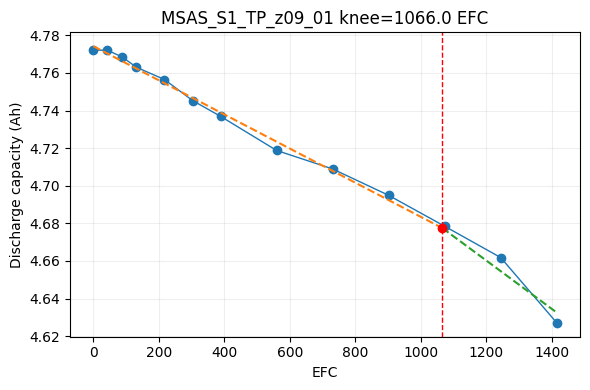

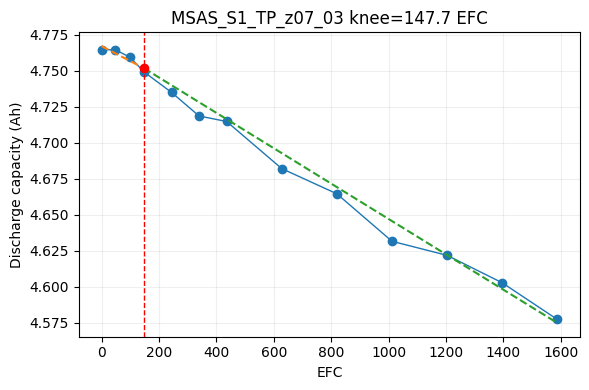

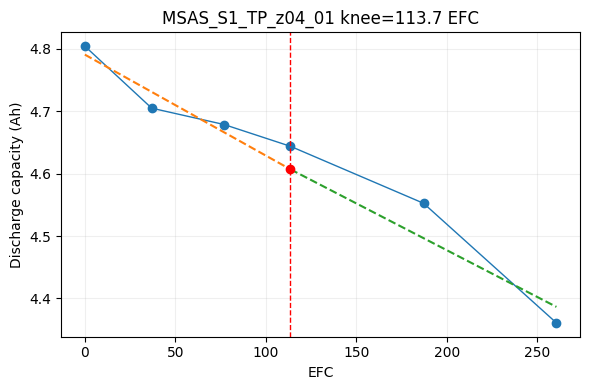

In [90]:
import batteryml.label.knee_efc as knee_mod

allowed_tag_set = set(allowed_tags)

def compute_capacity_points(cell):
    pts = []
    for c in (cell.cycle_data or []):
        meta = getattr(c, "additional_data", {}) or {}
        tag = meta.get("msas_tag")
        if tag not in allowed_tag_set:
            continue
        efc = meta.get("msas_efc")
        if efc is None or not np.isfinite(efc):
            continue
        q_end = knee_mod._cycle_q_end_ah(
            c,
            include_cv=False,
            cc_current_fraction=0.98,
            cv_voltage_window_in_V=0.05,
        )
        if q_end is None or not np.isfinite(q_end):
            continue
        pts.append((float(efc), float(q_end)))
    if not pts:
        return None
    grouped = {}
    for efc, q in pts:
        grouped.setdefault(efc, []).append(q)
    xs = np.array(sorted(grouped.keys()), dtype=float)
    ys = np.array([float(np.mean(grouped[x])) for x in xs], dtype=float)
    ys = np.minimum.accumulate(ys)
    return xs, ys

def piecewise_fit(x, y, min_points, min_slope_drop):
    n = len(x)
    if n < 2 * min_points:
        return None
    best = None
    for k in range(min_points - 1, n - min_points):
        x1, y1 = x[:k + 1], y[:k + 1]
        x2, y2 = x[k:], y[k:]
        try:
            a1, b1 = np.polyfit(x1, y1, 1)
            a2, b2 = np.polyfit(x2, y2, 1)
        except Exception:
            continue
        if a2 >= a1 - min_slope_drop:
            continue
        denom = a1 - a2
        if abs(denom) < 1e-12:
            continue
        x_star = (b2 - b1) / denom
        x_left = x[k]
        x_right = x[k + 1] if (k + 1) < n else x[k]
        x_star = min(max(x_star, x_left), x_right)
        y_star = a1 * x_star + b1
        y1_hat = a1 * x1 + b1
        y2_hat = a2 * x2 + b2
        sse = float(np.sum((y1 - y1_hat) ** 2) + np.sum((y2 - y2_hat) ** 2))
        if best is None or sse < best[0]:
            best = (sse, a1, b1, a2, b2, x_star, y_star, k)
    return best

rng = np.random.default_rng(0)
knee_cells = df[df["has_knee"]]["cell_id"].tolist()
if len(knee_cells) == 0:
    print("No knee cells found.")
else:
    sample_ids = rng.choice(knee_cells, size=min(10, len(knee_cells)), replace=False)
    for cell_id in sample_ids:
        cell = BatteryData.load(processed_dir / f"{cell_id}.pkl")
        pts = compute_capacity_points(cell)
        if pts is None:
            continue
        x, y = pts
        best = piecewise_fit(x, y, min_points=min_points, min_slope_drop=min_slope_drop)
        if best is None:
            continue
        _, a1, b1, a2, b2, xk, yk, _ = best
        fig, ax = plt.subplots(figsize=(6, 4))
        ax.plot(x, y, marker="o", linewidth=1)
        ax.plot([x[0], xk], [a1 * x[0] + b1, yk], linestyle="--", color="#ff7f0e")
        ax.plot([xk, x[-1]], [yk, a2 * x[-1] + b2], linestyle="--", color="#2ca02c")
        ax.axvline(xk, color="red", linestyle="--", linewidth=1)
        ax.scatter([xk], [yk], color="red", zorder=5)
        ax.set_xlabel("EFC")
        ax.set_ylabel("Discharge capacity (Ah)")
        ax.set_title(f"{cell_id} knee={xk:.1f} EFC")
        ax.grid(True, alpha=0.2)
        plt.tight_layout()